# Breast Cancer
#### Model Comparison - Logistic Regression, Support Vector Machines, Random Forest, Ridge Classifier
Data source: https://pages.cs.wisc.edu/~olvi/uwmp/cancer.html , https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic


## Imports

In [114]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB

%matplotlib inline

In [342]:
# Constants

# Matplot styles 
STYLES = ['default', 'seaborn-v0_8-colorblind','seaborn-v0_8-white',
          'fivethirtyeight', 'ggplot']

FEATURES = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness',
            'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension','radius error',
            'texture error', 'perimeter error', 'area error','smoothness error', 'compactness error', 'concavity error',
            'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture',
            'worst perimeter', 'worst area','worst smoothness', 'worst compactness' ,'worst concavity',
            'worst concave points', 'worst symmetry', 'worst fractal dimension']
LABELS =['Malignant', 'Benign'] # as 0 and 1
CLASSES = 2
RANDOM_STATE = 11

# Plots
COLOURS = ['#ff5252', '#34ace0' ]
OFFSETS = [0.03, 0.03]

In [333]:
def produce_confusion_matrix(y_test, prediction,
                             classes=CLASSES,
                             labels=LABELS,
                             normalise=False):
    cm = confusion_matrix(y_true=y_test, y_pred=prediction)
    rows = cm.shape[0]
    cols = cm.shape[1]

    cmap=plt.cm.BuGn
    title='Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(classes)
    plt.xticks(tick_marks, labels, rotation=30, fontsize=14)
    plt.yticks(tick_marks, labels, fontsize=14)

    for i, j in itertools.product(range(rows), range(cols)):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment='center',
                color='white' if (cm[i,j] > cm.max() / 2.) else 'black')
    plt.tight_layout()
    plt.ylabel('Actual Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.show();
    return cm

def get_test_accuracy(model, x_test, y_test, prediction):
    nr_correct = (y_test == prediction).sum()
    nr_incorrect = (y_test.size - nr_correct).sum()
    print("<<< Test Data Inference >>>")
    print(f'Correct prediction counts: {nr_correct}\nIncorrect prediction counts: {nr_incorrect}')
    # Accuracy test
    accuracy = model.score(x_test, y_test)
    frac_wrong = nr_incorrect / len(y_test)
    print(f'Test Accuracy: {accuracy:.2%}\nThe rate of wrong prediction: {frac_wrong:.3%}')

# Precision
def get_precision(cm):
  true_pos = np.diag(cm)
  score = true_pos / np.sum(cm, axis=0) # true pos + true neg
  print("Precision")
  print(f'{LABELS}\n{score}')
  return score

# Recall
def get_recall(cm):
  true_pos = np.diag(cm)
  score = true_pos / np.sum(cm, axis=1) # true pos + false neg
  print("Recall")
  print(f'{LABELS}\n{score}')
  return score


# F1-score
def get_f_1_score(cm, y_true, y_hat):
    """
    this computes unweighted F1 scores: by class and averaged unweighted
    also prints out precision and recall scores for each class
    """
    recall = get_recall(cm)
    precision = get_precision(cm)

    avg_recall = np.mean(recall)
    avg_prec = np.mean(precision)

    f1 = 2 * ((avg_recall * avg_prec) / (avg_recall + avg_prec))
    print(f'Unweighted F1 Score: {f1:.4f}')
    print(f'F1 score for each class: {LABELS}\n{f1_score(y_true, y_hat, average=None)}')

    weighted_f1 = f1_score(y_true, y_hat, average='weighted')
    print(f'Weighted overall F1: {weighted_f1:.4f}')

# Data

### Load data and explore

In [32]:
data = load_breast_cancer(as_frame=True)
print(data.feature_names)
df =  data.data

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [34]:
target = data.target

In [35]:
df['target'] = target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [36]:
# save to csv file
#df.to_csv("bc.csv")

In [37]:
# Check for null/empty values
print(df.isna().any())
print(df.isnull().any())
df.info(show_counts = True)

mean radius                False
mean texture               False
mean perimeter             False
mean area                  False
mean smoothness            False
mean compactness           False
mean concavity             False
mean concave points        False
mean symmetry              False
mean fractal dimension     False
radius error               False
texture error              False
perimeter error            False
area error                 False
smoothness error           False
compactness error          False
concavity error            False
concave points error       False
symmetry error             False
fractal dimension error    False
worst radius               False
worst texture              False
worst perimeter            False
worst area                 False
worst smoothness           False
worst compactness          False
worst concavity            False
worst concave points       False
worst symmetry             False
worst fractal dimension    False
target    

In [42]:
# Descripttive stats of features
df.iloc[:, 0:30].describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [45]:
# Spearman rank correlation 
df.corr(method='spearman')

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.340956,0.997802,0.999602,0.148510,0.497578,0.645728,0.759702,0.120242,-0.349931,...,0.314911,0.971555,0.978863,0.125789,0.491357,0.596043,0.727265,0.174698,0.044564,-0.732785
mean texture,0.340956,1.000000,0.348142,0.344145,0.024649,0.266499,0.342646,0.306891,0.110130,-0.059303,...,0.909218,0.375273,0.368335,0.101401,0.290917,0.339725,0.319235,0.120693,0.116144,-0.461971
mean perimeter,0.997802,0.348142,1.000000,0.997068,0.182923,0.543925,0.681958,0.788629,0.150049,-0.304891,...,0.323109,0.978980,0.980864,0.156611,0.534565,0.632106,0.757526,0.199007,0.088961,-0.748496
mean area,0.999602,0.344145,0.997068,1.000000,0.138053,0.488988,0.642557,0.755165,0.113928,-0.358425,...,0.318178,0.971822,0.980264,0.119712,0.485813,0.593736,0.723390,0.170860,0.038758,-0.734122
mean smoothness,0.148510,0.024649,0.182923,0.138053,1.000000,0.678806,0.518511,0.565172,0.542228,0.588465,...,0.060645,0.226345,0.191735,0.796085,0.481384,0.429107,0.498868,0.393579,0.511457,-0.371892
mean compactness,0.497578,0.266499,0.543925,0.488988,0.678806,1.000000,0.896518,0.848295,0.552203,0.499195,...,0.255305,0.592254,0.531590,0.578902,0.901029,0.837921,0.825473,0.450333,0.688986,-0.609288
mean concavity,0.645728,0.342646,0.681958,0.642557,0.518511,0.896518,1.000000,0.927352,0.446793,0.258174,...,0.335866,0.722424,0.676628,0.488775,0.849985,0.938543,0.904938,0.383667,0.541838,-0.733308
mean concave points,0.759702,0.306891,0.788629,0.755165,0.565172,0.848295,0.927352,1.000000,0.423767,0.142659,...,0.300562,0.813960,0.780395,0.490035,0.758309,0.827281,0.937075,0.355477,0.421110,-0.777877
mean symmetry,0.120242,0.110130,0.150049,0.113928,0.542228,0.552203,0.446793,0.423767,1.000000,0.428467,...,0.118890,0.190526,0.154462,0.424230,0.440828,0.394481,0.397477,0.710359,0.410069,-0.332567
mean fractal dimension,-0.349931,-0.059303,-0.304891,-0.358425,0.588465,0.499195,0.258174,0.142659,0.428467,1.000000,...,-0.047791,-0.247456,-0.304927,0.493474,0.403653,0.242611,0.139152,0.295046,0.760771,0.025903


### Preprocessing

### Visaulise data

In [1]:
# Pair plots - Errors on display on GitHub
# sns.pairplot(df, hue='target')
# plt.show();

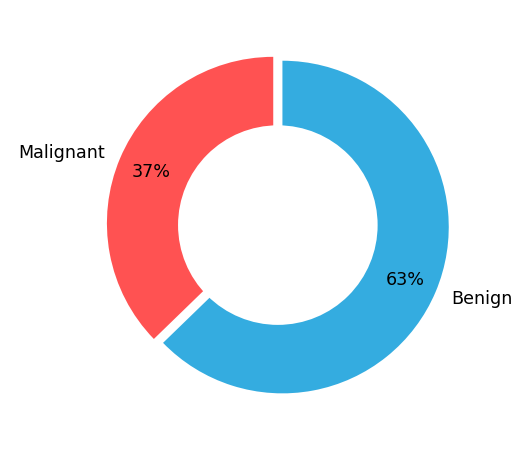

In [113]:
# Pie chart for class distribution
benign_count = (df['target'] == 1).sum()
malignant_count = (df['target'] == 0).sum()
size = [malignant_count, benign_count]

#Pie chart
plt.figure(figsize=(3, 3), dpi=180)
plt.pie(size,
        labels=LABELS,
        colors=COLOURS,
        textprops={'fontsize': 7},
        startangle=90,
        autopct='%1.0f%%',
        pctdistance=0.8,
        explode=OFFSETS)
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')  #coordinates, radius, centre colour
plt.gca().add_artist(centre_circle) # get current axis and add new circle to it

plt.show()

### Split data

In [326]:
X = df.iloc[:, :30] # features
Y = df['target'] # label
print(f'X {X.shape}, Y = {Y.shape}')

X (569, 30), Y = (569,)


In [327]:
# Data spllit
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

In [328]:
# Normalise data
#scaler = PowerTransformer() # similar to Standard S
scaler = StandardScaler() # best
#scaler = MinMaxScaler()  # worst
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
print(f'x_train size: {x_train.shape}, y_train size: {len(y_train)}')
print(f'x_test size: {x_test.shape}, y_test size: {len(y_test)}')

x_train size: (455, 30), y_train size: 455
x_test size: (114, 30), y_test size: 114


# 1. Logistic regression


### Train and evaluation

In [329]:
model_logistic = LogisticRegression(random_state=RANDOM_STATE)
model_logistic.fit(x_train, y_train)
print('intercept', model_logistic.intercept_)
# generate a dataframe with coefficients of each features
print(pd.DataFrame(data=model_logistic.coef_[0], index=FEATURES, columns=['coef']))
train_accuracy = model_logistic.score(x_train, y_train)
print(f'Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')

intercept [0.02774539]
                             coef
mean radius             -0.368427
mean texture            -0.441215
mean perimeter          -0.370161
mean area               -0.445102
mean smoothness          0.079793
mean compactness         0.609884
mean concavity          -0.865112
mean concave points     -0.985457
mean symmetry           -0.056798
mean fractal dimension   0.410179
radius error            -1.152372
texture error            0.339742
perimeter error         -0.774087
area error              -0.904724
smoothness error        -0.326179
compactness error        0.587149
concavity error          0.157245
concave points error    -0.243579
symmetry error           0.389763
fractal dimension error  0.484990
worst radius            -0.864037
worst texture           -1.239886
worst perimeter         -0.784026
worst area              -0.838299
worst smoothness        -0.768940
worst compactness        0.062425
worst concavity         -0.708353
worst concave points    -

### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 112
Incorrect prediction counts: 2
Test Accuracy: 98.25%
The rate of wrong prediction: 1.754%


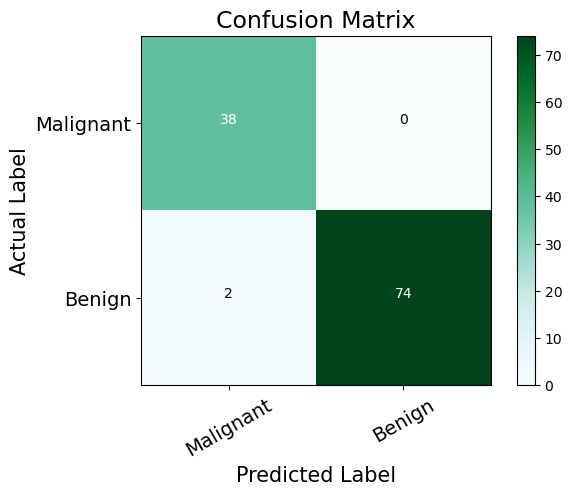

Recall
['Malignant', 'Benign']
[1.         0.97368421]
Precision
['Malignant', 'Benign']
[0.95 1.  ]
Unweighted F1 Score: 0.9809
F1 score for each class: ['Malignant', 'Benign']
[0.97435897 0.98666667]
Weighted overall F1: 0.9826


In [334]:
# Make prediction using test data
pred_logistic = model_logistic.predict(x_test)
get_test_accuracy(model=model_logistic, x_test=x_test, y_test=y_test, prediction=pred_logistic)
# confusion Matrix and f1
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_logistic)
get_f_1_score(cm=cm,y_true=y_test, y_hat=pred_logistic)

# 2. Support Vector Machine

### Train and evaluation

In [335]:
#model_svc = LinearSVC(penalty='l2', C=1.5, max_iter=1_000)  # second best
model_svc = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1_000) # best
model_svc.fit(x_train, y_train)

print('intercept', model_svc.intercept_)
# generate a dataframe with coefficients of each features - only for linear models
#print(pd.DataFrame(data=model_svc.coef_[0], index=FEATURES, columns=['coef']))
train_accuracy = model_svc.score(x_train, y_train)
print(f'SVC Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')


intercept [-0.23129352]
SVC Train accuracy = 0.989, 98.90%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 112
Incorrect prediction counts: 2
Test Accuracy: 98.25%
The rate of wrong prediction: 1.754%


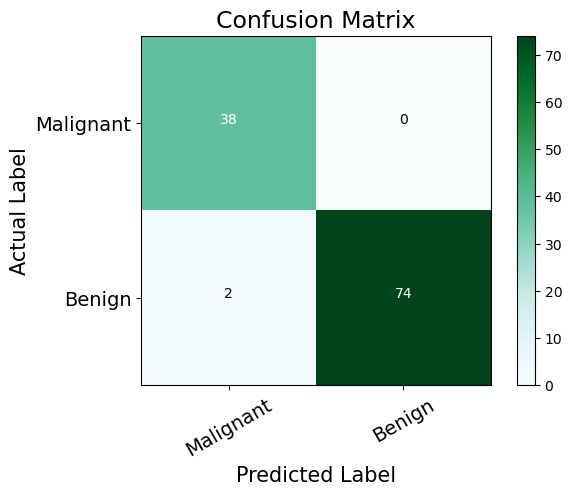

Recall
['Malignant', 'Benign']
[1.         0.97368421]
Precision
['Malignant', 'Benign']
[0.95 1.  ]
Unweighted F1 Score: 0.9809
F1 score for each class: ['Malignant', 'Benign']
[0.97435897 0.98666667]
Weighted overall F1: 0.9826


In [336]:
pred_svc = model_svc.predict(x_test)
# Accuracy
get_test_accuracy(model=model_svc, x_test=x_test, y_test=y_test, prediction=pred_svc)
#
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_svc)
get_f_1_score(cm=cm,y_true=y_test, y_hat=pred_svc)

# 3. Random Forests (The Winner)

### Train and evaluation

In [337]:
model_rf = RandomForestClassifier(n_estimators=32, random_state=55) # 32-55 combination
model_rf.fit(x_train, y_train)
train_accuracy = model_rf.score(x_train, y_train)
print(f'Random Forests Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')

Random Forests Train accuracy = 1.000, 100.00%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 114
Incorrect prediction counts: 0
Test Accuracy: 100.00%
The rate of wrong prediction: 0.000%


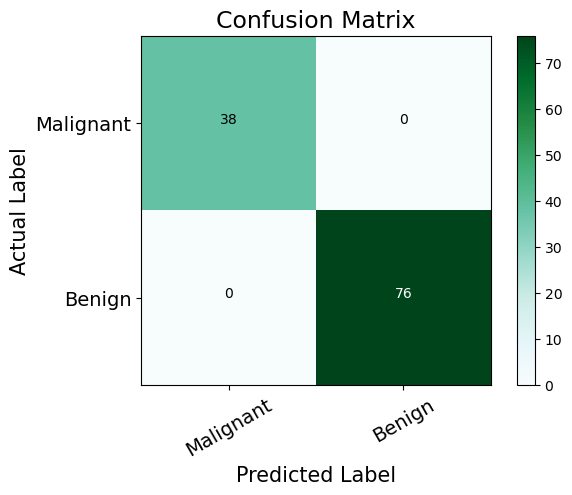

Recall
['Malignant', 'Benign']
[1. 1.]
Precision
['Malignant', 'Benign']
[1. 1.]
Unweighted F1 Score: 1.0000
F1 score for each class: ['Malignant', 'Benign']
[1. 1.]
Weighted overall F1: 1.0000


In [338]:
pred_rf = model_rf.predict(x_test)
get_test_accuracy(model=model_rf, x_test=x_test, y_test=y_test, prediction=pred_rf)
#
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_rf)
get_f_1_score(cm=cm, y_true=y_test, y_hat=pred_rf)

# 4.  Ridge Classifier

In [340]:
model_rc = RidgeClassifier(alpha=1.0, solver='svd', random_state=RANDOM_STATE)
model_rc.fit(x_train, y_train)

print('intercept', model_rc.intercept_)
train_accuracy = model_rc.score(x_train, y_train)
pred_rc = model_rc.predict(x_test)
print(f'Ridge Classifier Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')

intercept [0.23516484]
Ridge Classifier Train accuracy = 0.965, 96.48%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 110
Incorrect prediction counts: 4
Test Accuracy: 96.49%
The rate of wrong prediction: 3.509%


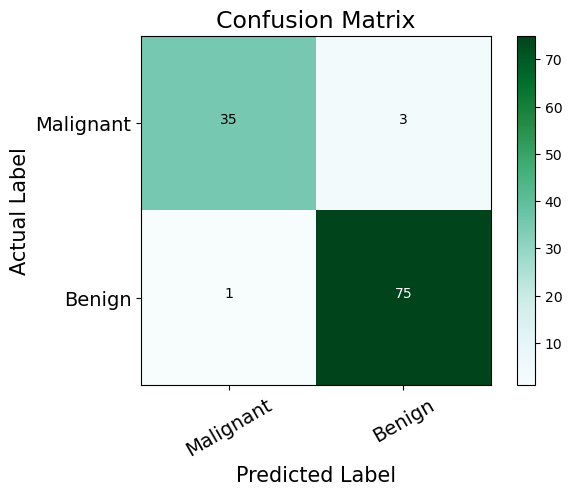

Recall
['Malignant', 'Benign']
[0.92105263 0.98684211]
Precision
['Malignant', 'Benign']
[0.97222222 0.96153846]
Unweighted F1 Score: 0.9604
F1 score for each class: ['Malignant', 'Benign']
[0.94594595 0.97402597]
Weighted overall F1: 0.9647


In [341]:
pred_rc = model_rc.predict(x_test)
get_test_accuracy(model=model_rc, x_test=x_test, y_test=y_test, prediction=pred_rc)
#
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_rc)
get_f_1_score(cm=cm, y_true=y_test, y_hat=pred_rc)

#### Random Forests performs best with a test accuracy 100%!